In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
data = pd.read_csv('/content/cars.csv')

In [3]:
data

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,price_usd,is_exchangeable,location_region,number_of_photos,up_counter,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,universal,False,owned,all,10900.00,False,Минская обл.,9,13,False,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,universal,False,owned,all,5000.00,True,Минская обл.,12,54,False,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,suv,False,owned,all,2800.00,True,Минская обл.,4,72,False,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,sedan,False,owned,all,9999.00,True,Минская обл.,9,42,True,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,universal,False,owned,all,2134.11,True,Гомельская обл.,14,7,False,True,False,True,True,False,False,False,False,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,Chrysler,300,automatic,silver,290000,2000,gasoline,False,gasoline,3.5,sedan,False,owned,front,2750.00,True,Минская обл.,5,85,False,True,False,False,True,True,False,False,True,True,301
38527,Chrysler,PT Cruiser,mechanical,blue,321000,2004,diesel,False,diesel,2.2,hatchback,False,owned,front,4800.00,True,Брестская обл.,4,20,False,True,False,False,True,True,False,False,True,True,317
38528,Chrysler,300,automatic,blue,777957,2000,gasoline,False,gasoline,3.5,sedan,False,owned,front,4300.00,False,Минская обл.,3,63,False,True,False,False,True,True,False,False,True,True,369
38529,Chrysler,PT Cruiser,mechanical,black,20000,2001,gasoline,False,gasoline,2.0,minivan,False,owned,front,4000.00,True,Брестская обл.,7,156,False,True,False,False,False,False,False,False,False,True,490


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38531 entries, 0 to 38530
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  38531 non-null  object 
 1   model_name         38531 non-null  object 
 2   transmission       38531 non-null  object 
 3   color              38531 non-null  object 
 4   odometer_value     38531 non-null  int64  
 5   year_produced      38531 non-null  int64  
 6   engine_fuel        38531 non-null  object 
 7   engine_has_gas     38531 non-null  bool   
 8   engine_type        38531 non-null  object 
 9   engine_capacity    38521 non-null  float64
 10  body_type          38531 non-null  object 
 11  has_warranty       38531 non-null  bool   
 12  state              38531 non-null  object 
 13  drivetrain         38531 non-null  object 
 14  price_usd          38531 non-null  float64
 15  is_exchangeable    38531 non-null  bool   
 16  location_region    385

# Filling Missing Values

In [5]:
print("Total missing values:", data.isna().sum().sum())

Total missing values: 10


In [6]:
print("Columns with missing values:", data.columns[data.isna().sum() > 0].values)

Columns with missing values: ['engine_capacity']


In [7]:
data['engine_capacity'].dtype

dtype('float64')

In [8]:
data['engine_capacity'] = data['engine_capacity'].fillna(data['engine_capacity'].mean())

print("Total missing values:", data.isna().sum().sum())

Total missing values: 0


# Encoding Features

In [9]:
data

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,price_usd,is_exchangeable,location_region,number_of_photos,up_counter,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,universal,False,owned,all,10900.00,False,Минская обл.,9,13,False,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,universal,False,owned,all,5000.00,True,Минская обл.,12,54,False,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,suv,False,owned,all,2800.00,True,Минская обл.,4,72,False,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,sedan,False,owned,all,9999.00,True,Минская обл.,9,42,True,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,universal,False,owned,all,2134.11,True,Гомельская обл.,14,7,False,True,False,True,True,False,False,False,False,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,Chrysler,300,automatic,silver,290000,2000,gasoline,False,gasoline,3.5,sedan,False,owned,front,2750.00,True,Минская обл.,5,85,False,True,False,False,True,True,False,False,True,True,301
38527,Chrysler,PT Cruiser,mechanical,blue,321000,2004,diesel,False,diesel,2.2,hatchback,False,owned,front,4800.00,True,Брестская обл.,4,20,False,True,False,False,True,True,False,False,True,True,317
38528,Chrysler,300,automatic,blue,777957,2000,gasoline,False,gasoline,3.5,sedan,False,owned,front,4300.00,False,Минская обл.,3,63,False,True,False,False,True,True,False,False,True,True,369
38529,Chrysler,PT Cruiser,mechanical,black,20000,2001,gasoline,False,gasoline,2.0,minivan,False,owned,front,4000.00,True,Брестская обл.,7,156,False,True,False,False,False,False,False,False,False,True,490


First let's just make all the boolean columns into integer columns.

In [10]:
for column in data.columns:
    if data.dtypes[column] == 'bool':
        data[column] = data[column].astype(np.int)

Then we will take a look at the number of unique values in each categorical column.

In [11]:
{column: len(data[column].unique()) for column in data.columns if data.dtypes[column] == 'object'}

{'body_type': 12,
 'color': 12,
 'drivetrain': 3,
 'engine_fuel': 6,
 'engine_type': 3,
 'location_region': 6,
 'manufacturer_name': 55,
 'model_name': 1118,
 'state': 3,
 'transmission': 2}

*model_name* has too many unique values, so let's drop that feature.

In [12]:
data = data.drop('model_name', axis=1)

*transmission* has only two unique values, so we can encode it as a binary feature.

In [13]:
data['transmission'].unique()

array(['automatic', 'mechanical'], dtype=object)

In [14]:
transmission_mapping = {'automatic': 0, 'mechanical': 1}

data['transmission'] = data['transmission'].replace(transmission_mapping)

All the remaining features can be one-hot encoded.  
We will not encode *engine_type*, as that is our label column.

In [15]:
def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [16]:
onehot_columns = [
    'manufacturer_name',
    'color',
    'engine_fuel',
    'body_type',
    'state',
    'drivetrain',
    'location_region'
]

onehot_prefixes = [
    'm',
    'c',
    'e',
    'b',
    's',
    'd',
    'l'
]

data = onehot_encode(
    data,
    columns=onehot_columns,
    prefixes=onehot_prefixes
)

In [17]:
print("Remaining non-numeric columns:", (data.dtypes == 'object').sum())

Remaining non-numeric columns: 1


# Encoding Labels

In [18]:
data['engine_type'].unique()

array(['gasoline', 'diesel', 'electric'], dtype=object)

In [19]:
label_mapping = {
    'gasoline': 0,
    'diesel': 1,
    'electric': 2
}

data['engine_type'] = data['engine_type'].replace(label_mapping)

In [20]:
print("Remaining non-numeric columns:", (data.dtypes == 'object').sum())

Remaining non-numeric columns: 0


# Visualizing Correlations

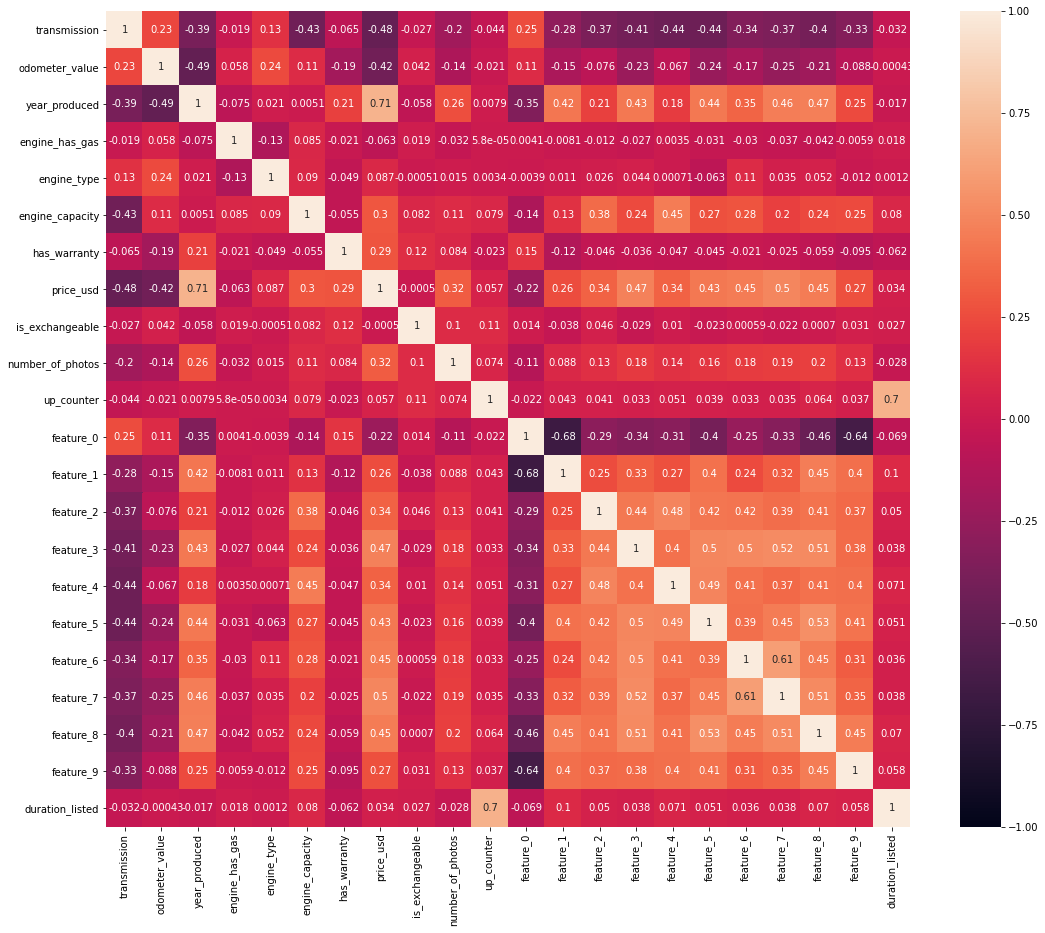

In [21]:
corr = data.loc[:, 'transmission':'duration_listed'].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='rocket')
plt.show()

# Splitting/Scaling

In [22]:
y = data['engine_type'].copy()
X = data.drop('engine_type', axis=1).copy()

In [23]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

# Modeling/Training

In [25]:
X.shape

(38531, 118)

In [ ]:
inputs = tf.keras.Input(shape=(118,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
675/675 [==============================] - 2s 2ms/step - loss: 0.2038 - accuracy: 0.9172 - val_loss: 9.3981e-04 - val_accuracy: 0.9998
Epoch 2/100
675/675 [==============================] - 1s 2ms/step - loss: 5.7638e-04 - accuracy: 1.0000 - val_loss: 2.1131e-04 - val_accuracy: 1.0000
Epoch 3/100
675/675 [==============================] - 1s 2ms/step - loss: 1.3073e-04 - accuracy: 1.0000 - val_loss: 1.1423e-04 - val_accuracy: 1.0000
Epoch 4/100
675/675 [==============================] - 1s 2ms/step - loss: 5.1974e-05 - accuracy: 1.0000 - val_loss: 7.8815e-05 - val_accuracy: 1.0000
Epoch 5/100
675/675 [==============================] - 1s 2ms/step - loss: 2.8061e-05 - accuracy: 1.0000 - val_loss: 5.5805e-05 - val_accuracy: 1.0000
Epoch 6/100
675/675 [==============================] - 1s 2ms/step - loss: 1.5634e-05 - accuracy: 1.0000 - val_loss: 4.4114e-05 - val_accuracy: 1.0000
Epoch 7/100
675/675 [==============================] - 1s 2ms/step - loss: 1.1108e-05 - accuracy: 

# Results

In [ ]:
model.evaluate(X_test, y_test)